In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats

### Loading and processing data

In [6]:
column_names = ['household_id','member_id', 'day_of_week', 
                'sex', 'living_env', 'age', 'working',
                'sleeping', 'reading','dining','visiting_lib']

habits = pd.read_csv('habits.data', sep=';', header=None, names=column_names, skiprows=1)

habits

,household_id,member_id,day_of_week,sex,living_env,age,working,sleeping,reading,dining,visiting_lib
0,50002,1,1,1,1.0,49,0,560,0,80,1.0
1,50002,1,2,1,1.0,49,380,450,10,0,1.0
2,50003,1,1,2,2.0,41,0,470,30,100,1.0
3,50003,1,2,2,2.0,41,0,550,0,0,1.0
4,50004,2,1,1,1.0,62,640,410,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
740,51980,1,2,2,2.0,50,460,450,31,0,2.0
741,51981,2,1,1,1.0,35,0,470,0,140,?
742,51981,2,2,1,1.0,35,0,730,?,0,?
743,51983,1,1,2,3.0,66,560,375,20,0,1.0


#### Clean data

In [ ]:
activity_cols = ["sleeping","reading","dining", "working"] # time-in-minutes activity columns

# Convert activity data to numeric or 0 if missing or invalid for all activity columns except visiting library
def clean_activity_value(x):
    if pd.isna(x): return np.nan
    x = str(x).strip()

    # mark missing
    if x in {"", "?", "-"} or ":" in x:
        return np.nan
    try:
        v = float(x)
        return np.nan if v < 0 or v > 1440 else v
    except:
        return np.nan

for col in activity_cols:
    habits[col] = habits[col].apply(clean_activity_value)
    
# Convert data in visiting_lib to binary 1 (yes) and 2 (no)
def clean_visiting_lib(x):
    if pd.isna(x):
        return 2
    x = str(x).strip()

    if x == '?' or x == '':
        return 2
    try:
        val = float(x)
        return 1 if val == 1 or val > 2 else 2
    except:
        return 2
habits['visiting_lib'] = habits['visiting_lib'].apply(clean_visiting_lib).map({1: 'Yes', 2: 'No'})

# handle categorical variables
categorical = {
    "day_of_week": ("working day", "weekend"),
    "sex": ("male", "female"),
    "living_env": ("city", "municipality", "rural area")
}

# update dataframe to make variables categorical
for col in categorical:
    s = pd.Categorical(habits[col]).rename_categories(categorical[col])
    habits[col] = s

# update age groups following the bins and labels
bins = [10, 15, 20, 25, 35, 45, 55, 65, 75, 100]
labels = ['10–14', '15–19', '20–24', '25–34', '35–44', '45–54', '55–64', '65–74', '75+']
habits['age_group'] = pd.cut(habits['age'], bins=bins, labels=labels, right=False)

habits

,household_id,member_id,day_of_week,sex,living_env,age,working,sleeping,reading,dining,visiting_lib,age_group
0,50002,1,working day,male,city,49,0.0,560.0,0.0,80.0,Yes,45–54
1,50002,1,weekend,male,city,49,380.0,450.0,10.0,0.0,Yes,45–54
2,50003,1,working day,female,municipality,41,0.0,470.0,30.0,100.0,Yes,35–44
3,50003,1,weekend,female,municipality,41,0.0,550.0,0.0,0.0,Yes,35–44
4,50004,2,working day,male,city,62,640.0,410.0,0.0,0.0,Yes,55–64
...,...,...,...,...,...,...,...,...,...,...,...,...
740,51980,1,weekend,female,municipality,50,460.0,450.0,31.0,0.0,No,45–54
741,51981,2,working day,male,city,35,0.0,470.0,0.0,140.0,No,35–44
742,51981,2,weekend,male,city,35,0.0,730.0,NaN,0.0,No,35–44
743,51983,1,working day,female,rural area,66,560.0,375.0,20.0,0.0,Yes,65–74


### Characterize the individuals that are present in the data.

Working: mean=120.6 min, median=0.0, SD=208.1, range=1050.0, IQR=200.0


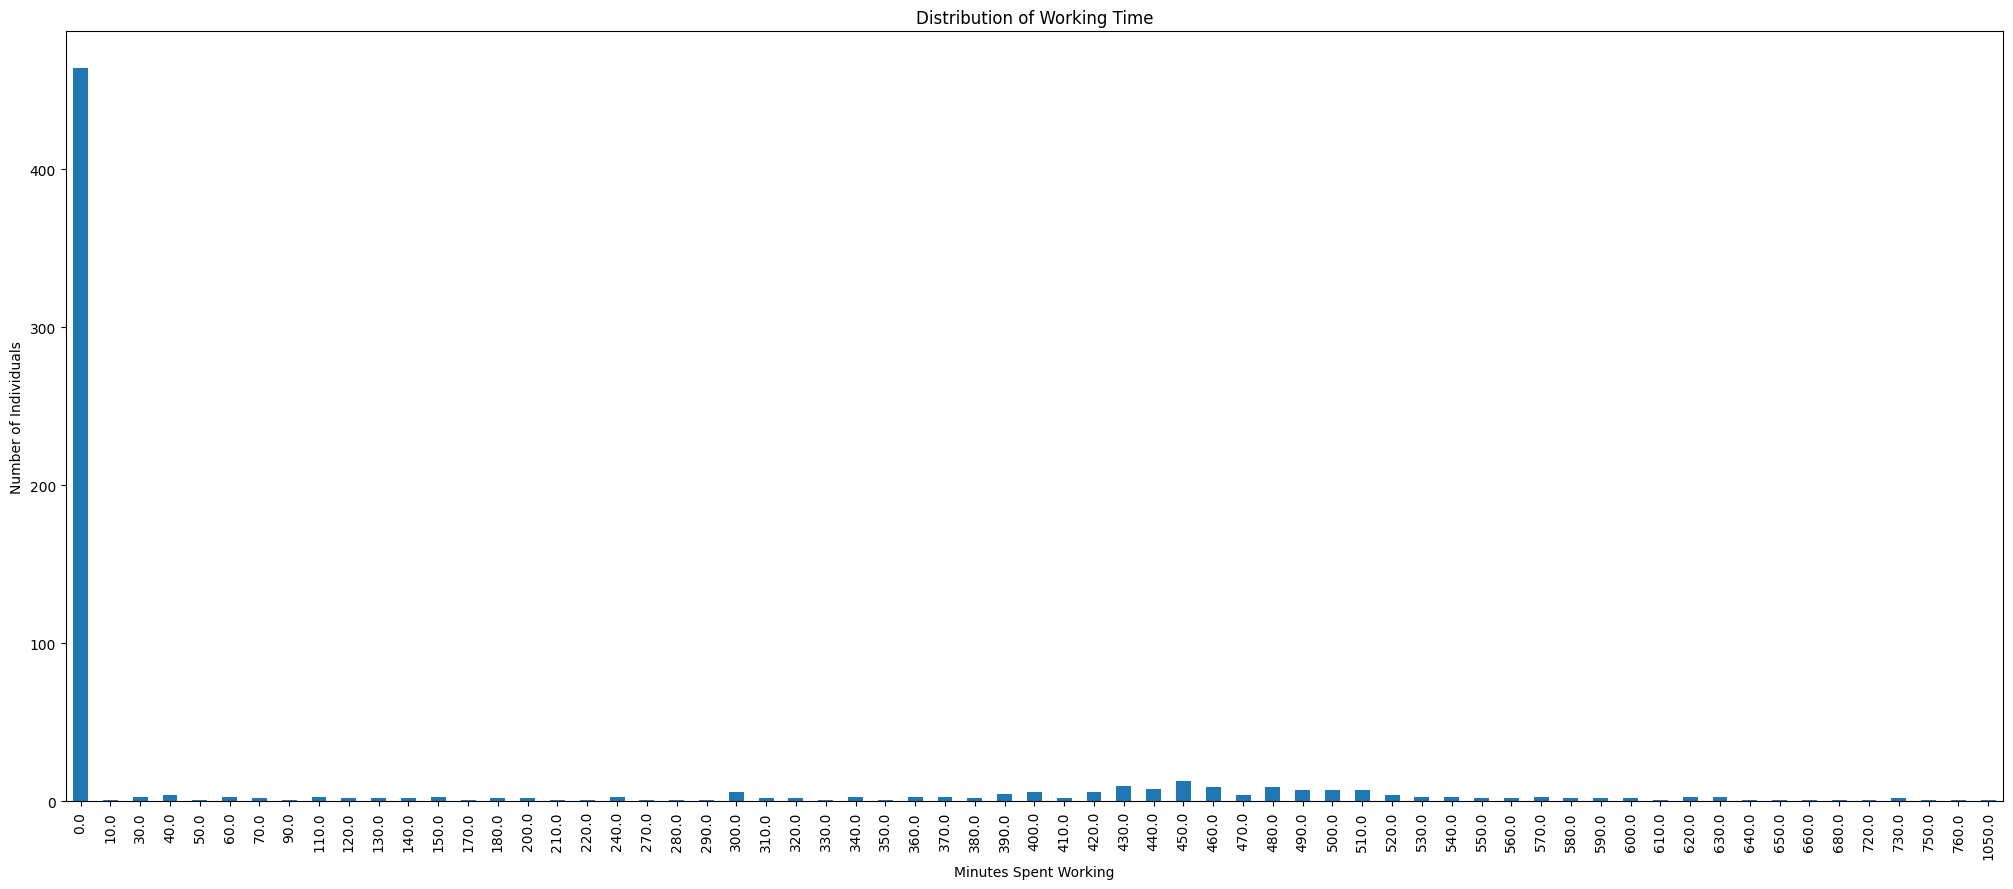

In [8]:
#Descriptive Statistic

#Working
work = habits['working'].dropna()
iqr = work.quantile(0.75) - work.quantile(0.25)
range_ = work.max() - work.min()
print(f"Working: mean={work.mean():.1f} min, median={work.median():.1f}, SD={work.std():.1f}, range={range_}, IQR={iqr:.1f}")

work_counts = habits['working'].value_counts().sort_index()

# Plot
work_counts.plot.bar(figsize=(25, 10))
plt.xlabel("Minutes Spent Working")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Working Time")
plt.show()

- Most individuals spend very little time working on a typical day (median = 0), but the mean is 120 minutes because a smaller number of people work much longer, pulling the average up. The high standard deviation (208) and large range (1050) indicate high variability. The distribution is right-skewed since mean > median.

Sleeping: mean=520.0 min, median=515.0, SD=100.7, range=830.0, IQR=115.0


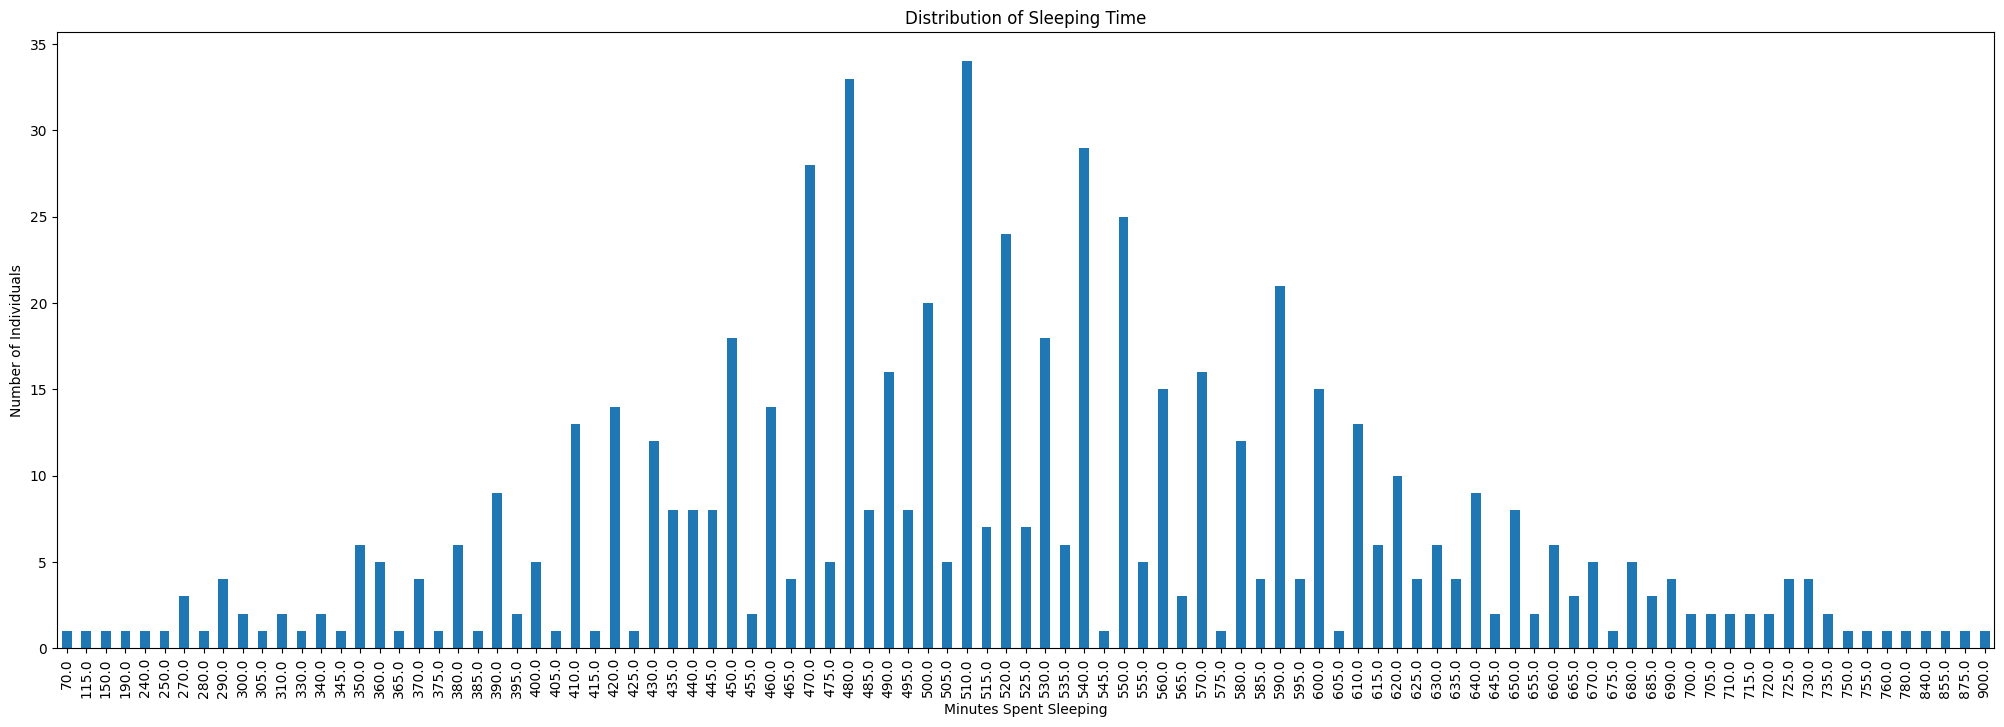

In [12]:
#Sleeping
sleep = habits['sleeping'].dropna()
iqr = sleep.quantile(0.75) - sleep.quantile(0.25)
range_ = sleep.max() - sleep.min()
print(f"Sleeping: mean={sleep.mean():.1f} min, median={sleep.median():.1f}, SD={sleep.std():.1f}, range={range_}, IQR={iqr:.1f}")


sleep_counts = habits['sleeping'].value_counts().sort_index()

# Plot
sleep_counts.plot.bar(figsize=(25, 8))
plt.xlabel("Minutes Spent Sleeping")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Sleeping Time")
plt.show()

- Finnish individuals sleep on average 520 minutes per day (≈8.7 hours). The median is close to the mean, suggesting the distribution is roughly symmetric. The IQR of 115 minutes shows moderate variability in sleeping habits, while the large range (830 minutes) indicates some extreme cases (very short or long sleepers).

Reading: mean=48.0 min, median=30.0, SD=64.0, range=404.0, IQR=70.0


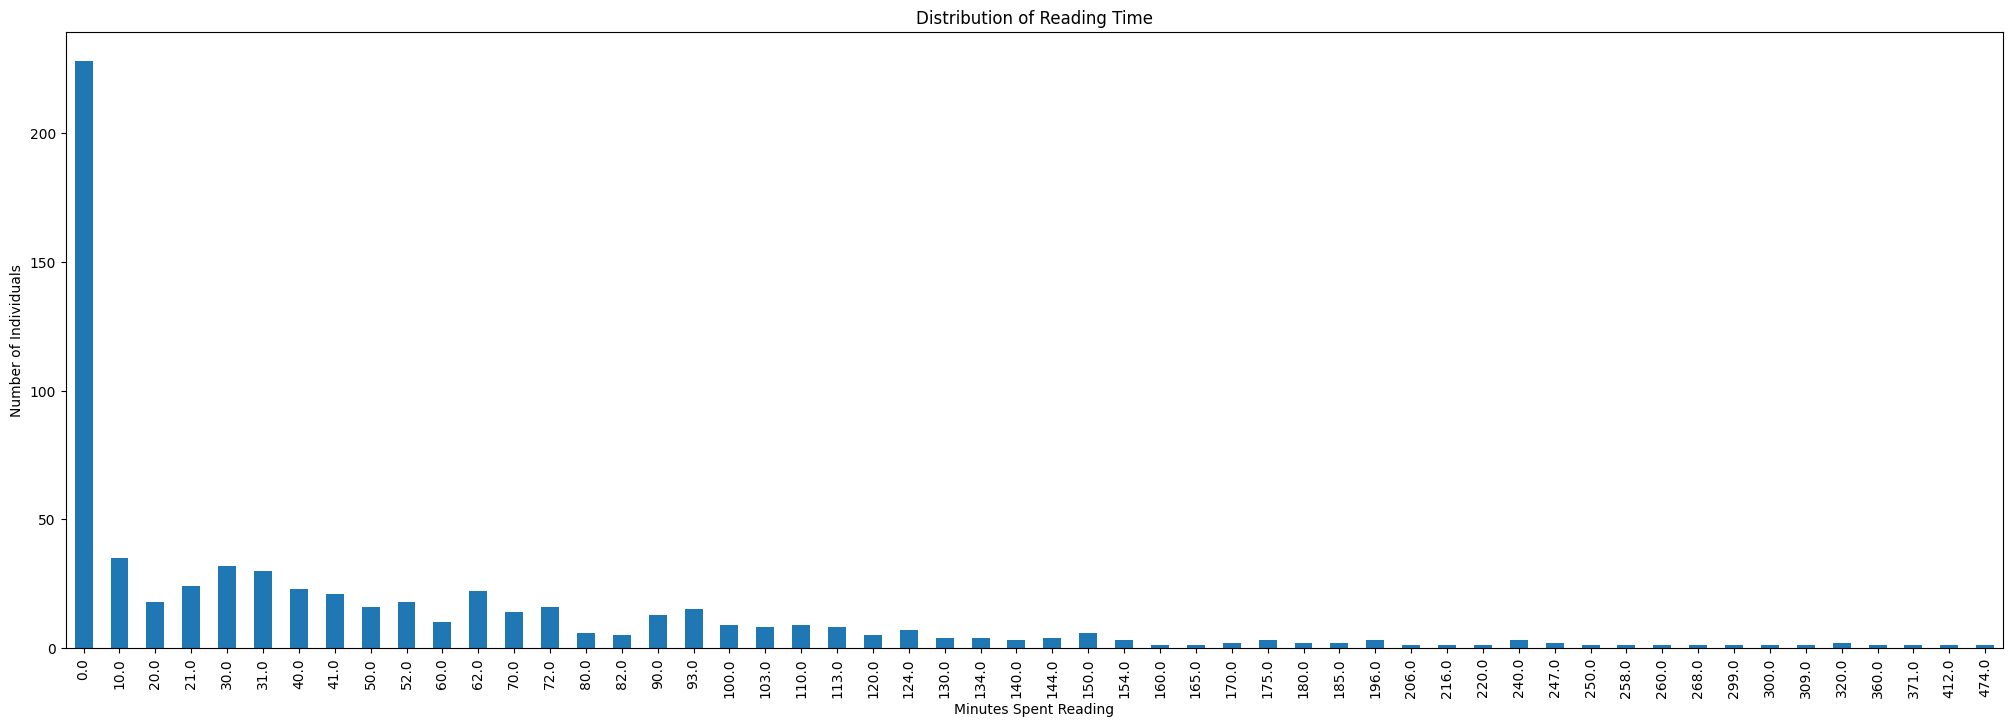

In [13]:
#Reading
read = habits['reading'].dropna()
iqr = read.quantile(0.75) - read.quantile(0.25)
range_ = read.max() - sleep.min()
print(f"Reading: mean={read.mean():.1f} min, median={read.median():.1f}, SD={read.std():.1f}, range={range_}, IQR={iqr:.1f}")

read_counts = habits['reading'].value_counts().sort_index()

# Plot
read_counts.plot.bar(figsize=(25, 8))
plt.xlabel("Minutes Spent Reading")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Reading Time")
plt.show()

- On average, individuals spend 48 minutes reading per day. The median is lower than the mean, showing a right-skewed distribution, where some people read a lot more than most. The IQR of 70 minutes indicates moderate variability in typical reading time, but the very large range (404 minutes) suggests a few extreme cases. 

Dining: mean=48.5 min, median=0.0, SD=58.6, range=240.0, IQR=100.0


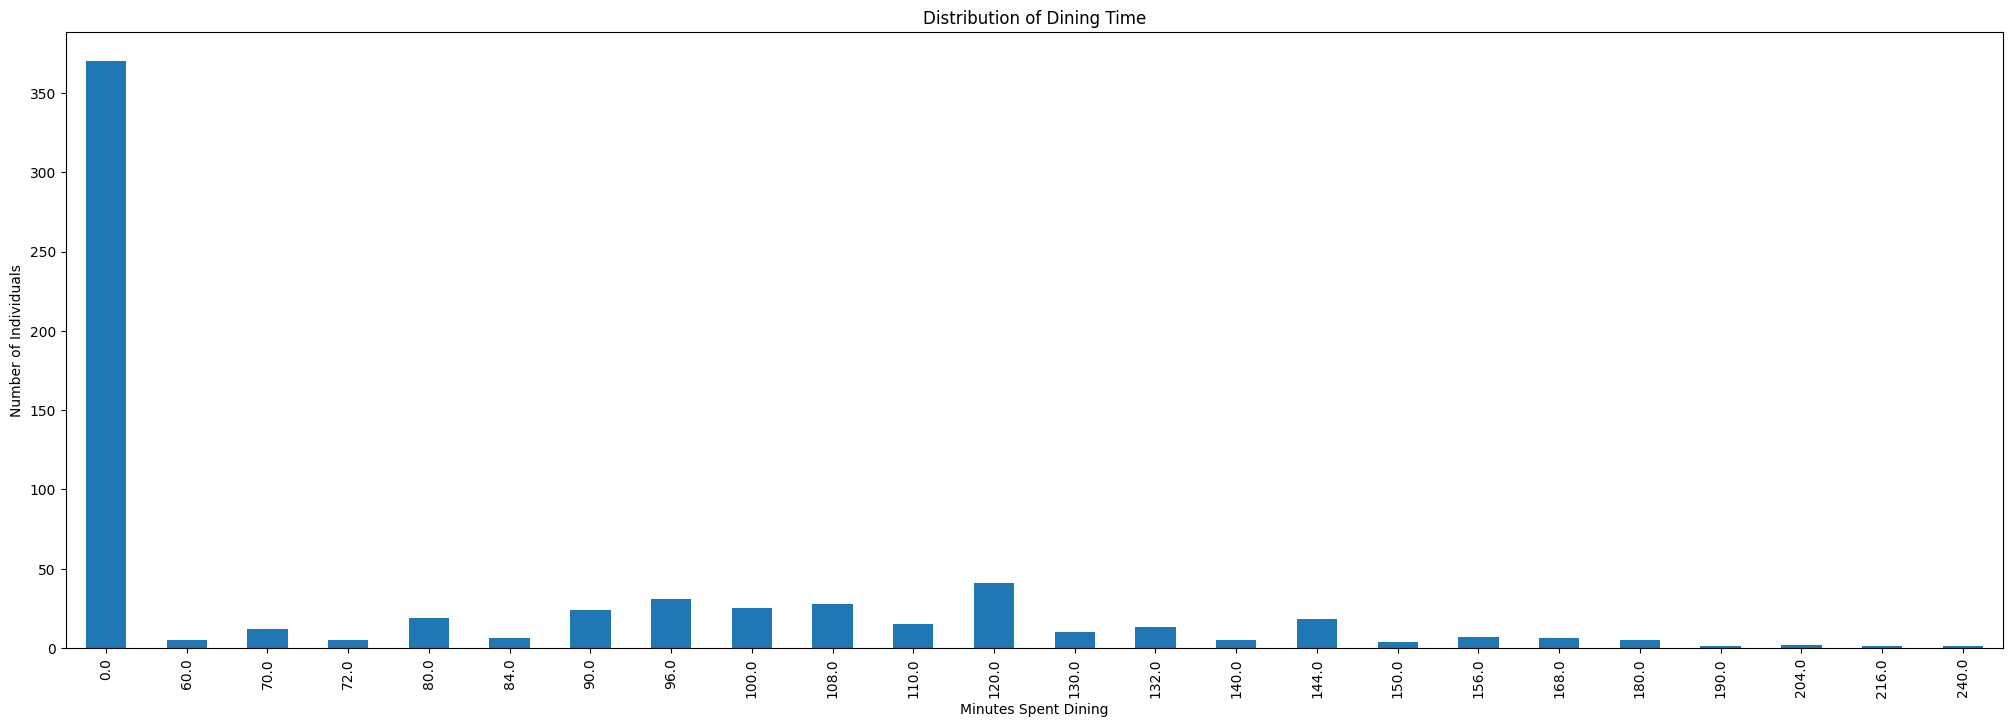

In [14]:
#Dining
dine = habits['dining'].dropna()
iqr = dine.quantile(0.75) - dine.quantile(0.25)
range_ = dine.max() - dine.min()
print(f"Dining: mean={dine.mean():.1f} min, median={dine.median():.1f}, SD={dine.std():.1f}, range={range_}, IQR={iqr:.1f}")

dine_counts = habits['dining'].value_counts().sort_index()

# Plot
dine_counts.plot.bar(figsize=(25, 8))
plt.xlabel("Minutes Spent Dining")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Dining Time")
plt.show()

- Most individuals do not spend much time dining on a typical day (median = 0), but the mean is higher because some spend substantial time dining. The distribution is heavily right-skewed, with high variability (SD = 58.6) and a wide range of 240 minutes.

Visiting Library:
Yes: 477 (64.0%)
No: 268 (36.0%)


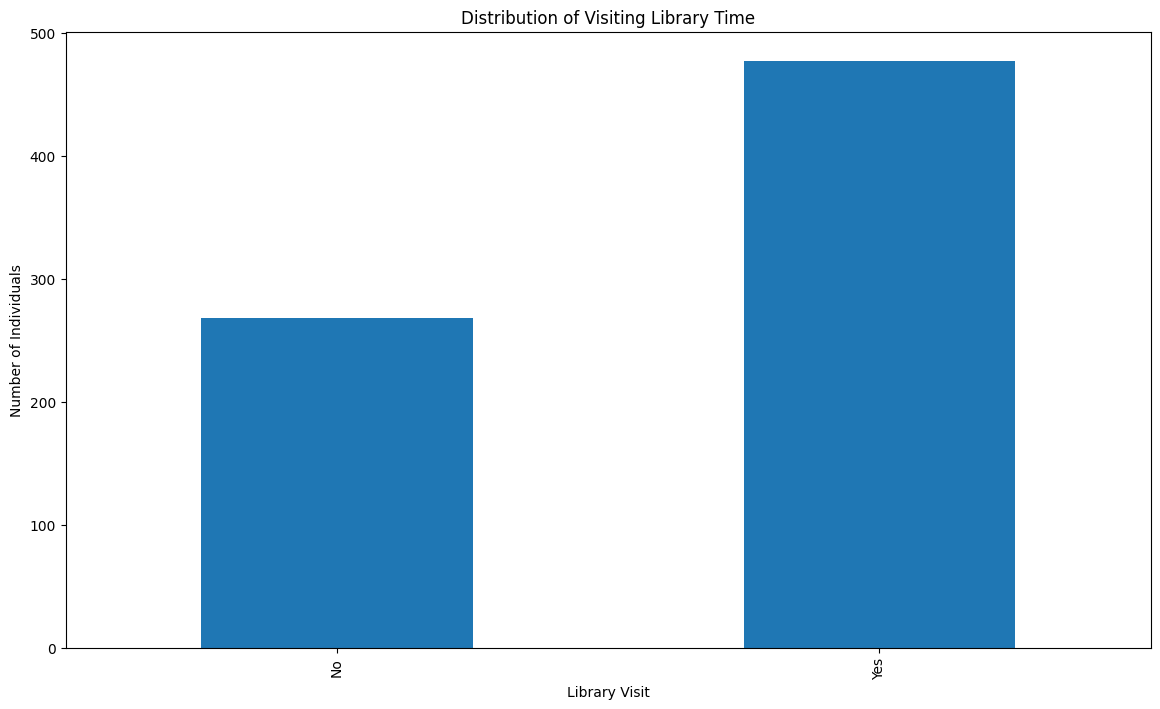

In [15]:
#Visiting
visit_lib = habits['visiting_lib'].dropna()
counts = visit_lib.value_counts()
percentages = visit_lib.value_counts(normalize=True) * 100
print("Visiting Library:")
for category in counts.index:
    print(f"{category}: {counts[category]} ({percentages[category]:.1f}%)")

visit_lib_counts = habits['visiting_lib'].value_counts().sort_index()

visit_lib_counts.plot.bar(figsize=(14, 8))
plt.xlabel("Library Visit")
plt.ylabel("Number of Individuals")
plt.title("Distribution of Visiting Library Time")
plt.show()

- About two-thirds of individuals report visiting the library. This categorical variable shows that library visits are fairly common, but a sizable minority (36%) do not visit at all.

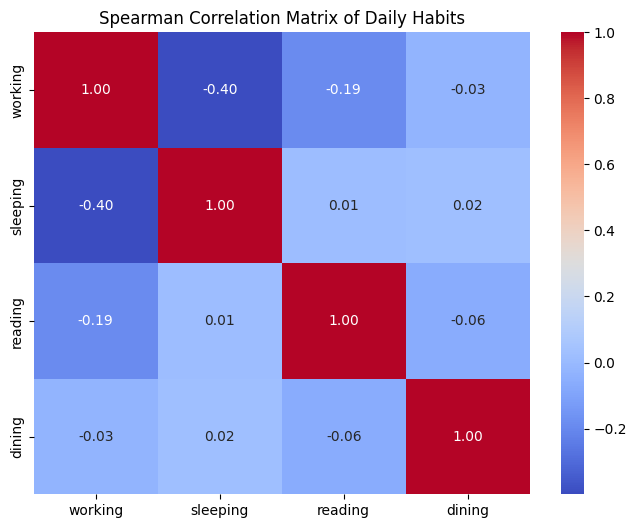

In [16]:
corr = habits[['working', 'sleeping', 'reading', 'dining']].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Matrix of Daily Habits")
plt.show()

In [ ]:
#Correlation between working, sleeping, reading, dining grouped by visiting_lib
corr_by_group = habits.groupby('visiting_lib').apply(lambda df: df[activity_cols].corr(method='spearman'))
print(corr_by_group)

                       sleeping   reading    dining   working
visiting_lib                                                 
No           sleeping  1.000000  0.031662  0.048499 -0.373168
             reading   0.031662  1.000000 -0.076862 -0.223734
             dining    0.048499 -0.076862  1.000000  0.011526
             working  -0.373168 -0.223734  0.011526  1.000000
Yes          sleeping  1.000000  0.005825  0.012146 -0.410273
             reading   0.005825  1.000000 -0.060686 -0.172934
             dining    0.012146 -0.060686  1.000000 -0.049272
             working  -0.410273 -0.172934 -0.049272  1.000000


C:\Users\HP\AppData\Local\Temp\ipykernel_4712\65934102.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_by_group = habits.groupby('visiting_lib').apply(lambda df: df[activity_cols].corr(method='spearman'))


In [19]:
#Correlation between working, sleeping, reading, dining grouped by visiting_lib
corr_by_group = habits.groupby('visiting_lib').apply(lambda df: df[activity_cols].corr(method='spearman'))
print(corr_by_group)

                       sleeping   reading    dining   working
visiting_lib                                                 
No           sleeping  1.000000  0.031662  0.048499 -0.373168
             reading   0.031662  1.000000 -0.076862 -0.223734
             dining    0.048499 -0.076862  1.000000  0.011526
             working  -0.373168 -0.223734  0.011526  1.000000
Yes          sleeping  1.000000  0.005825  0.012146 -0.410273
             reading   0.005825  1.000000 -0.060686 -0.172934
             dining    0.012146 -0.060686  1.000000 -0.049272
             working  -0.410273 -0.172934 -0.049272  1.000000


C:\Users\HP\AppData\Local\Temp\ipykernel_4712\65934102.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_by_group = habits.groupby('visiting_lib').apply(lambda df: df[activity_cols].corr(method='spearman'))


In [17]:
###PCA
# select time-in-minutes activity columns
X = habits[activity_cols].dropna() 

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# create a dataframe with PCA results
pca_df = pd.DataFrame(data=X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
pca_df = pd.concat([pca_df, habits[['sex', 'age_group', 'living_env', 'day_of_week']].reset_index(drop=True)], axis=1)

# explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio by each principal component:")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f}")
    
# Interpreting components based on loadings
loadings = pd.DataFrame(
    pca.components_.T,
    index=activity_cols,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)
print(loadings.round(2))

Explained variance ratio by each principal component:
PC1: 0.3579
PC2: 0.2690
           PC1   PC2
sleeping -0.64 -0.30
reading  -0.27  0.72
dining   -0.08 -0.61
working   0.71 -0.07


In [18]:
# top features contributing to each principal component
for i in range(pca.n_components_):
    pc = f'PC{i+1}'
    sorted_loadings = loadings[pc].abs().sort_values(ascending=False)
    top_features = sorted_loadings.head(3).index.tolist()
    print(f"Top features contributing to {pc}: {top_features}")

Top features contributing to PC1: ['working', 'sleeping', 'reading']
Top features contributing to PC2: ['reading', 'dining', 'sleeping']


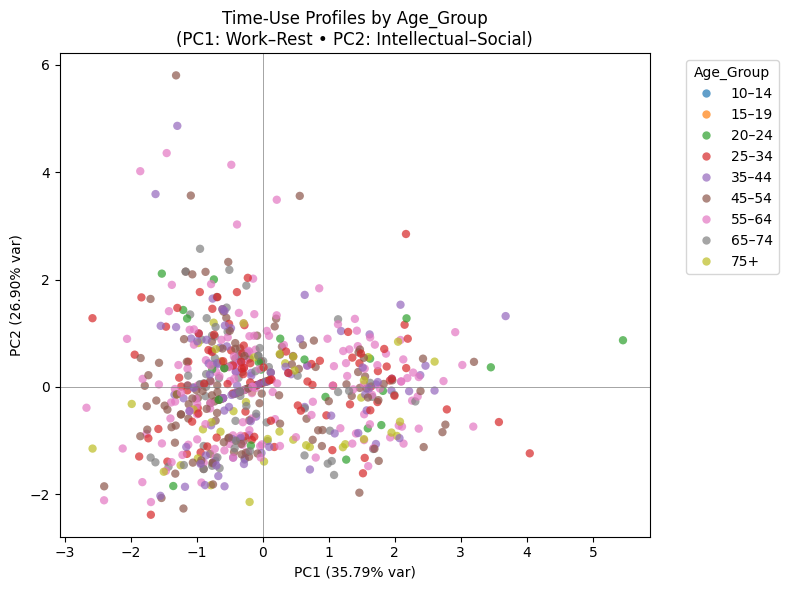

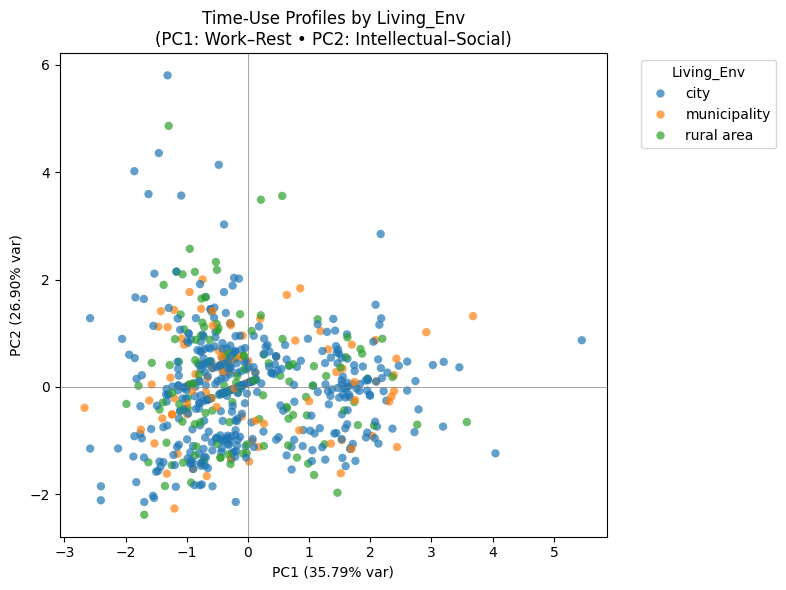

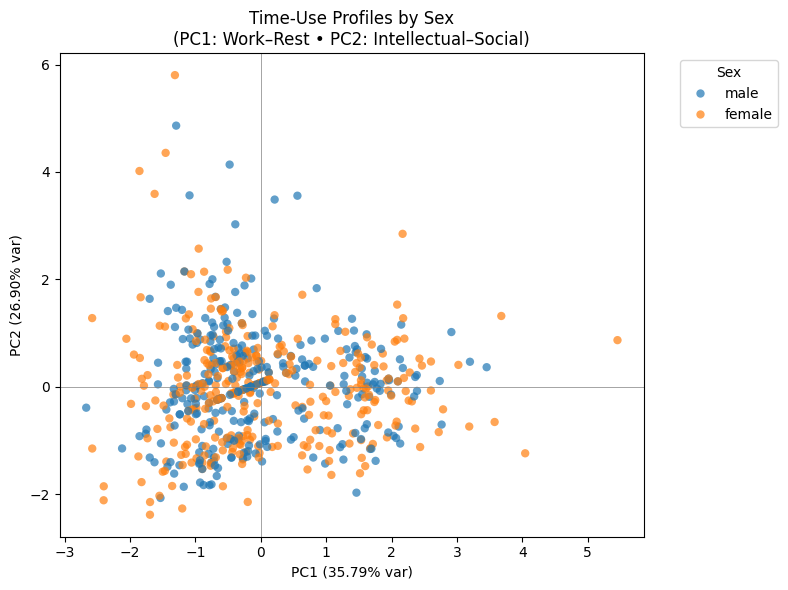

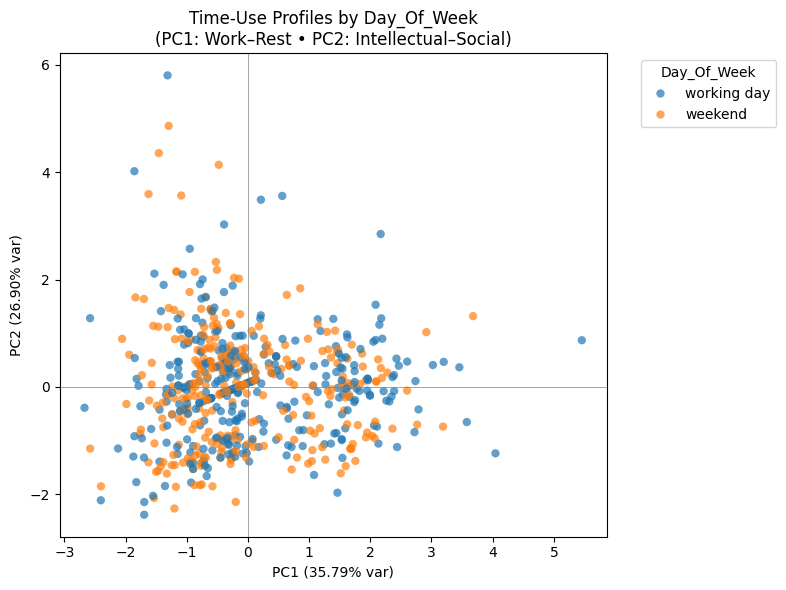

In [19]:
# Scatter plot by group variable
group_vars = ["age_group", "living_env", "sex", "day_of_week"]

for group_var in group_vars:
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=pca_df,
        x="PC1", y="PC2",
        hue=group_var,
        palette="tab10",
        alpha=0.7,
        edgecolor="none"
    )
    plt.axhline(0, color="gray", lw=0.5)    
    plt.axvline(0, color="gray", lw=0.5)
    plt.title(f"Time-Use Profiles by {group_var.title()}\n"
          f"(PC1: Work–Rest • PC2: Intellectual–Social)")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% var)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% var)")
    plt.legend(title=group_var.title(), bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [20]:
visiting_summary = (
    habits.groupby(["age_group", "living_env", "sex", "day_of_week"], observed=True)["visiting_lib"]
    .value_counts(normalize=True)
    .rename("proportion")
    .mul(100)
    .reset_index()
)

visiting_summary = visiting_summary[visiting_summary["visiting_lib"] == "Yes"]

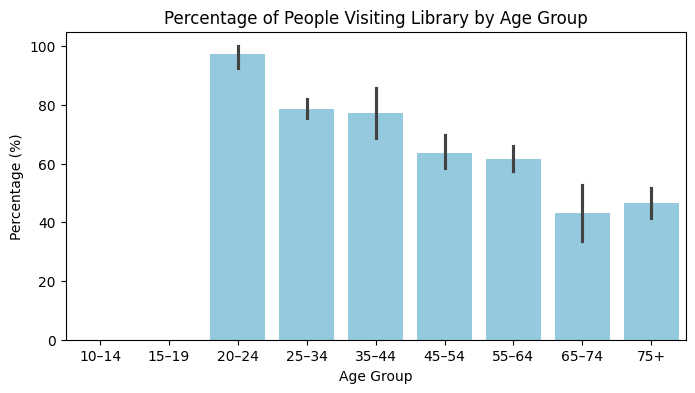

In [21]:
plt.figure(figsize=(8,4))
sns.barplot(data=visiting_summary, x="age_group", y="proportion", color="skyblue")
plt.title("Percentage of People Visiting Library by Age Group")
plt.ylabel("Percentage (%)")
plt.xlabel("Age Group")
plt.show()

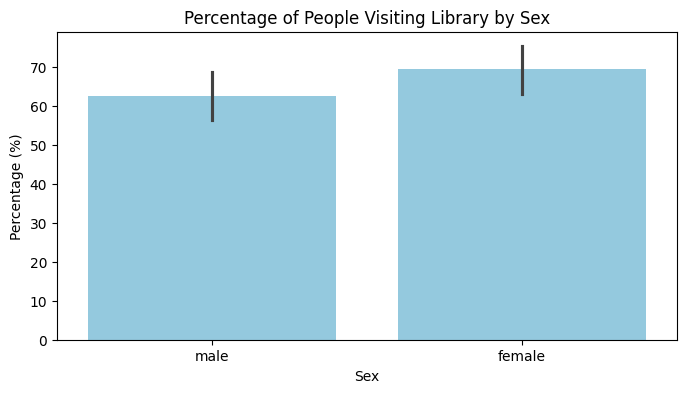

In [22]:
plt.figure(figsize=(8,4))
sns.barplot(data=visiting_summary, x="sex", y="proportion", color="skyblue")
plt.title("Percentage of People Visiting Library by Sex")
plt.ylabel("Percentage (%)")
plt.xlabel("Sex")
plt.show()

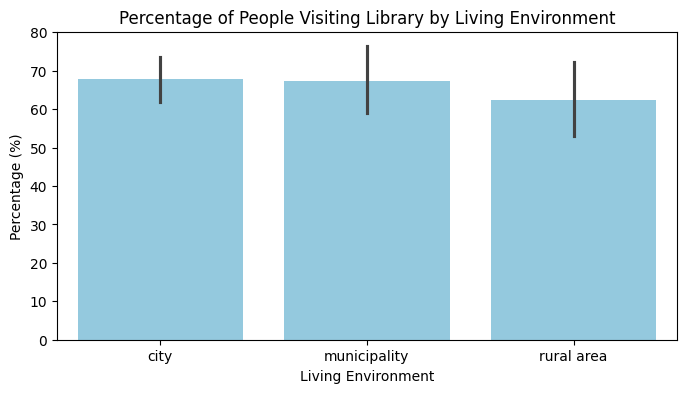

In [23]:
plt.figure(figsize=(8,4))
sns.barplot(data=visiting_summary, x="living_env", y="proportion", color="skyblue")
plt.title("Percentage of People Visiting Library by Living Environment")
plt.ylabel("Percentage (%)")
plt.xlabel("Living Environment")
plt.show()

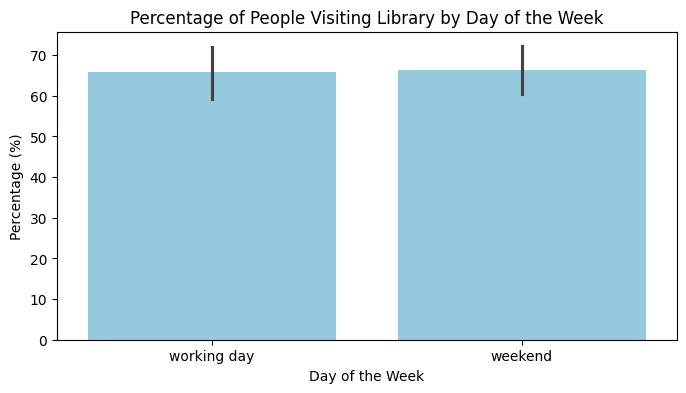

In [24]:
plt.figure(figsize=(8,4))
sns.barplot(data=visiting_summary, x="day_of_week", y="proportion", color="skyblue")
plt.title("Percentage of People Visiting Library by Day of the Week")
plt.ylabel("Percentage (%)")
plt.xlabel("Day of the Week")
plt.show()

### Estimate how much time on average Finnish households spend daily on each activity.

In [25]:
# Group by household_id to get total daily time per household for reading, dining, sleeping, working
household_means = habits.groupby('household_id')[activity_cols].mean().reset_index()
household_means

,household_id,sleeping,reading,dining,working
0,50002,505.0,5.0,40.0,190.0
1,50003,510.0,15.0,50.0,0.0
2,50004,480.0,36.0,54.0,320.0
3,50005,545.0,46.0,108.0,0.0
4,50006,535.0,31.0,45.0,0.0
...,...,...,...,...,...
373,51971,470.0,96.5,65.0,340.0
374,51973,610.0,0.0,54.0,0.0
375,51980,510.0,15.5,0.0,230.0
376,51981,600.0,0.0,70.0,0.0


In [26]:
# Estimates and confidence intervals for activities (household-level)
from statsmodels.stats.proportion import proportion_confint

# Time-in-minutes activities: compute household-level means and 95% t-based CIs
alpha = 0.05
rows = []
for col in activity_cols:
    col_data = household_means[col].dropna()
    n = len(col_data)
    if n == 0:
        rows.append({'activity': col, 'n_households': 0, 'mean': np.nan, 'lower': np.nan, 'upper': np.nan})
        continue
    mean = col_data.mean()
    std = col_data.std(ddof=1) 
    se = std / np.sqrt(n)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    lower = mean - tcrit * se
    upper = mean + tcrit * se
    rows.append({'activity': col, 'n_households': n, 'mean': mean, 'lower': lower, 'upper': upper})
cont_df = pd.DataFrame(rows).set_index('activity')
print('Household-level daily mean time (minutes) with 95% t-based CIs')
display(cont_df.round(2))

# Visiting library (categorical) - compute proportions + Wilson CIs
# Household-level: whether any member of household visits library on that day
household_visit_any = habits.groupby('household_id')['visiting_lib'].apply(lambda s: (s == 'Yes').any()).astype(int)
successes_hh = household_visit_any.sum()
n_hh = len(household_visit_any)
prop_hh = successes_hh / n_hh if n_hh > 0 else np.nan
ci_low_hh, ci_upp_hh = proportion_confint(successes_hh, n_hh, method='wilson')

prop_df = pd.DataFrame({
    'activity': ['visiting_lib'],
    'n_households': [n_hh],
    'proportion': [prop_hh],
    'lower': [ci_low_hh],
    'upper': [ci_upp_hh]
}).set_index('activity')
print('Visiting library proportions (Wilson 95% CIs)')
display(prop_df.round(4))

Household-level daily mean time (minutes) with 95% t-based CIs


,n_households,mean,lower,upper
activity,,,,
sleeping,337,520.24,512.17,528.30
reading,337,48.60,42.15,55.04
dining,336,49.13,44.45,53.81
working,337,121.65,105.69,137.60


Visiting library proportions (Wilson 95% CIs)


,n_households,proportion,lower,upper
activity,,,,
visiting_lib,378,0.6402,0.5906,0.687


### With respect to which activities do living environments or days of week differ in Finland?

In [27]:
# Normality tests (Shapiro-Wilk) for each activity by living environment
for col in activity_cols:
    print(f"Normality test for {col}:")
    # Loop through each living environment
    for env in habits['living_env'].unique():
        group_data = habits.loc[habits['living_env'] == env, col].dropna()
        stat, p_value = stats.shapiro(group_data)
        print(f"  {env}: p = {p_value} - {'Normally distributed' if p_value > 0.05 else 'Not normally distributed'}")
    
    print("\n")

Normality test for sleeping:
  city: p = 0.00011459566005316585 - Not normally distributed
  municipality: p = 0.04482118576301803 - Not normally distributed
  rural area: p = 0.0029831989448382357 - Not normally distributed


Normality test for reading:
  city: p = 1.4938780975943843e-24 - Not normally distributed
  municipality: p = 3.997699447003886e-12 - Not normally distributed
  rural area: p = 1.2532347347227427e-12 - Not normally distributed


Normality test for dining:
  city: p = 6.393647832175217e-24 - Not normally distributed
  municipality: p = 6.522381922566437e-13 - Not normally distributed
  rural area: p = 2.3237894644523475e-13 - Not normally distributed


Normality test for working:
  city: p = 2.566238406305706e-30 - Not normally distributed
  municipality: p = 2.625367827202195e-13 - Not normally distributed
  rural area: p = 1.3035146362968e-16 - Not normally distributed




In [28]:
# Normality tests (Shapiro-Wilk) for each activity by day of the week
for col in activity_cols:
    print(f"Normality test for {col}:")
    # Loop through each living environment
    for env in habits['day_of_week'].unique():
        group_data = habits.loc[habits['day_of_week'] == env, col].dropna()
        stat, p_value = stats.shapiro(group_data)
        print(f"  {env}: p = {p_value} - {'Normally distributed' if p_value > 0.05 else 'Not normally distributed'}")
    
    print("\n")

Normality test for sleeping:
  working day: p = 7.756852063411232e-05 - Not normally distributed
  weekend: p = 0.0007115004546123587 - Not normally distributed


Normality test for reading:
  working day: p = 1.7877821523666665e-22 - Not normally distributed
  weekend: p = 5.58814631729725e-22 - Not normally distributed


Normality test for dining:
  working day: p = 1.9350780031866671e-22 - Not normally distributed
  weekend: p = 6.531800621211474e-21 - Not normally distributed


Normality test for working:
  working day: p = 2.754019277152251e-26 - Not normally distributed
  weekend: p = 2.111459877323687e-26 - Not normally distributed




In [29]:
# statistical tests for time-in-minutes activities by living environment using Kruskal-Wallis
for col in activity_cols:
    print(f"Kruskal-Wallis test for {col}:")

    # Group data by living environment or day of the week
    groups = [habits.loc[habits['living_env'] == env, col].dropna() 
              for env in habits['living_env'].unique()]
    stat, p_value = stats.kruskal(*groups)
    print(f"  p = {p_value:.4f}")

# statistical test for living environment for visiting library using Pearson's chi-squared test 
chi2, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(habits['living_env'], habits['visiting_lib']))
print(f"Chi-squared test for visiting library: \n  p = {p_value:.4f}")

Kruskal-Wallis test for sleeping:
  p = 0.0688
Kruskal-Wallis test for reading:
  p = 0.0004
Kruskal-Wallis test for dining:
  p = 0.6624
Kruskal-Wallis test for working:
  p = 0.1401
Chi-squared test for visiting library: 
  p = 0.0258


In [31]:
habits['participant_id'] = habits['household_id'].astype(str) + '_' + habits['member_id'].astype(str)

# Filter data for working day and weekend
habits_working = habits[habits['day_of_week'] == 'working day']
habits_weekend = habits[habits['day_of_week'] == 'weekend']

# Check if there are participants with data for both working day and weekend
paired_participants = habits_working['participant_id'].isin(habits_weekend['participant_id'])
has_paired_data = paired_participants.any()
print(f"Has paired data: {has_paired_data}")

Has paired data: True


In [32]:
# Statistical tests for time-in-minutes activities by day of week using Wilcoxon signed-rank test
for col in activity_cols:
    print(f"Wilcoxon signed-rank test for {col}:")

    # Merge working day and weekend data on participant_id to ensure paired comparison
    merged = pd.merge(
        habits_working[['participant_id', col]].dropna(),
        habits_weekend[['participant_id', col]].dropna(),
        on='participant_id',
        suffixes=('_working', '_weekend')
    )

    if merged.shape[0] < 10:
        print("  Not enough paired data for Wilcoxon test.")
        continue

    stat, p_value = stats.wilcoxon(merged[f'{col}_working'], merged[f'{col}_weekend'])
    print(f"  p = {p_value:.4f}")

# Statistical test for day_of_week for visiting library using Pearson's chi-squared test
chi2, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(habits['day_of_week'], habits['visiting_lib']))
print(f"Chi-squared test for visiting library: \n  p = {p_value:.4f}")

Wilcoxon signed-rank test for sleeping:
  p = 0.6116
Wilcoxon signed-rank test for reading:
  p = 0.0040
Wilcoxon signed-rank test for dining:
  p = 0.0019
Wilcoxon signed-rank test for working:
  p = 0.9204
Chi-squared test for visiting library: 
  p = 0.7739


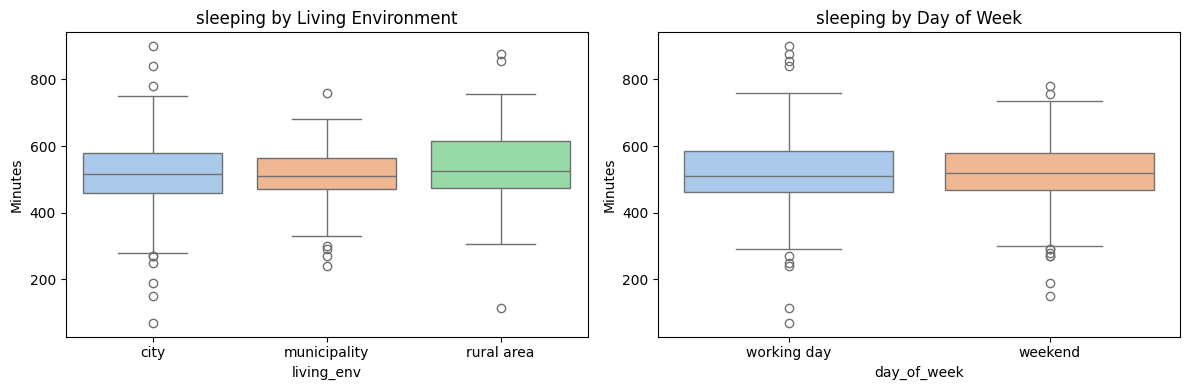

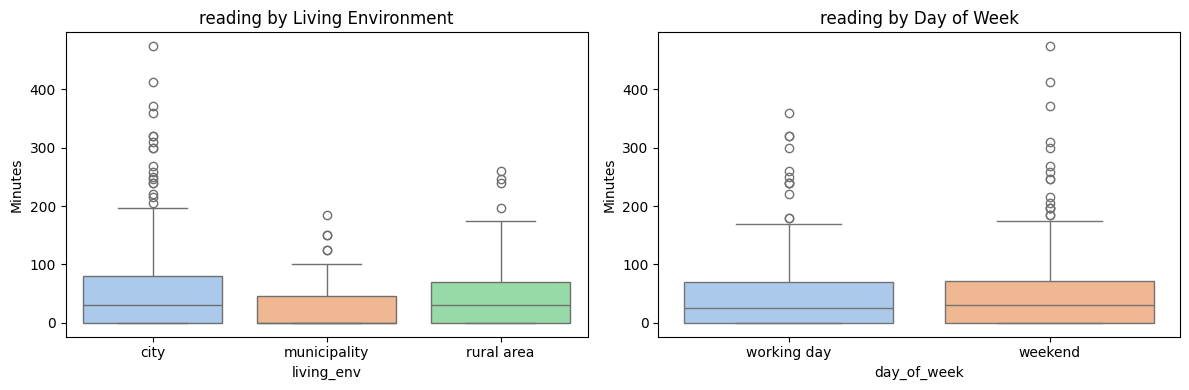

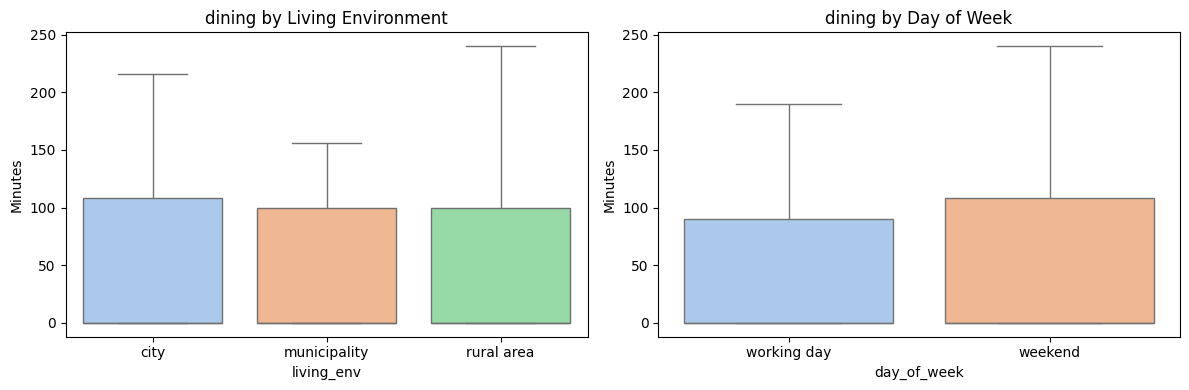

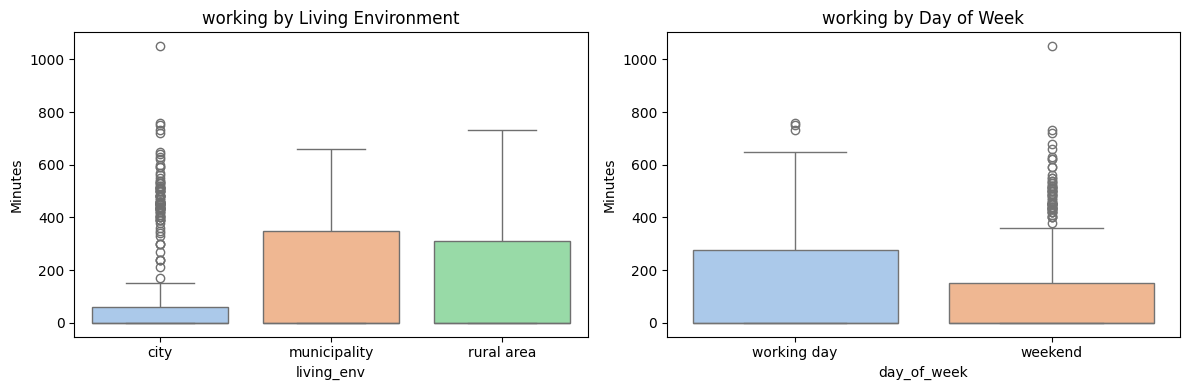

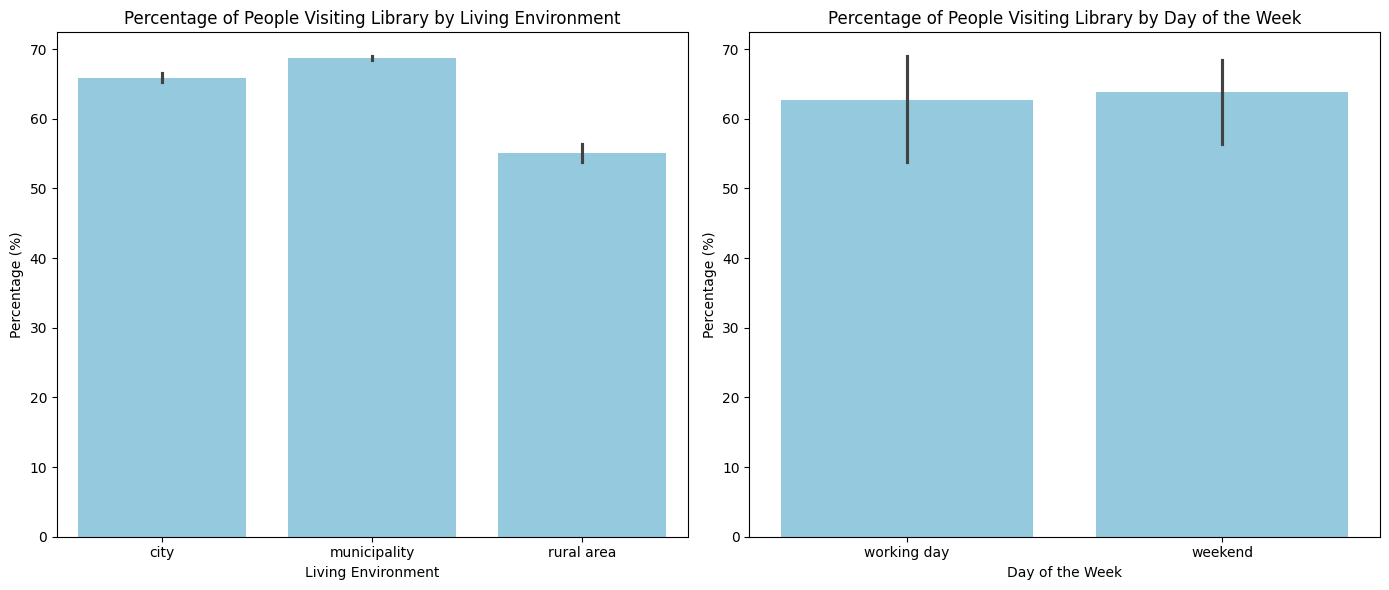

In [33]:
# Visualizations: boxplots by living_env and day_of_week for time-in-minutes activities
for act in activity_cols:
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.boxplot(data=habits, x='living_env', y=act, palette='pastel', hue='living_env', legend=False)
    plt.title(f'{act} by Living Environment')
    plt.ylabel('Minutes')
    plt.subplot(1,2,2)
    sns.boxplot(data=habits, x='day_of_week', y=act, palette='pastel', hue='day_of_week', legend=False)
    plt.title(f'{act} by Day of Week')
    plt.ylabel('Minutes')
    plt.tight_layout()
    plt.show()

# bar plot for visiting library rate by living_env / day_of_week
visiting_summary = (
    habits.groupby(["living_env", "day_of_week"], observed=True)["visiting_lib"]
    .value_counts(normalize=True)
    .rename("proportion")
    .mul(100)
    .reset_index()
)
visiting_summary = visiting_summary[visiting_summary["visiting_lib"] == "Yes"]
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(data=visiting_summary, x="living_env", y="proportion", color="skyblue", ax=ax[0])
ax[0].set_title("Percentage of People Visiting Library by Living Environment")
ax[0].set_ylabel("Percentage (%)")
ax[0].set_xlabel("Living Environment")
sns.barplot(data=visiting_summary, x="day_of_week", y="proportion", color="skyblue", ax=ax[1])
ax[1].set_title("Percentage of People Visiting Library by Day of the Week")
ax[1].set_ylabel("Percentage (%)")
ax[1].set_xlabel("Day of the Week")
plt.tight_layout()
plt.show()



### Which activities are associated with each other in Finnish population?(Descriptive statistics, PCA, Interpretation)